# Aula - Otimização de Hiperparâmetros

Hoje, vamos discutir como selecionar os melhores hiperparâmetros para um dado problema.

1. Introdução à otimização de hiperparâmetros.
2. Usando Grid Search
3. Usando Random Search
4. Usando Bayes Search

# 1. Introdução à otimização de hiperparâmetros

Juntando o que foi visto no curso de estatística e o que foi visto até agora no curso de aprendizado de máquina, já aprendemos alguns modelos.

<font size=4> <b> Classificação </b> </font>
- Regressão Logística
- Árvore de decisão (CART)
- KNN


<font size=4> <b> Regressão </b> </font>
- Regressão Linear 
- Árvore de decisão (CART)
- KNN


Os de regressão logística e regressão linear não têm muitas escolhas prévias que se precisa fazer. Roda o modelo nos dados de treino, e é isso.

Já o KNN  e as árvores de decisão têm configurações intrínsecas que afetam completamente o resultado, como o número de vizinhos ("K") e a profundidade da árvore, respectivamente. Essas configurações a gente chama de __hiperparâmetros__, e eles controlam o aprendizado.

Queremos então descobrir quais hiperparâmetros vão me ajudar a gerar o melhor modelo possível para o meu problema. Para um ou até dois parâmetros esse processo pode ser feito facilmente "na mão". Porém, à medida que a quantidade de hiperparâmetros aumenta, a quantidade de testes que temos que fazer aumentará __exponencialmente__ e será bem útil fazer uso de algumas técnicas conhecidas.

## 1.1 Diferença entre hiperparâmetro e parâmetro

As nomenclaturas podem parecer um pouco confusas a primeira vista, mas são perceptíveis ao enxergar com mais atenção. 

O __parâmetro de um modelo é algo que será ajustado no processo de treinamento dele e depende dos dados__. Os parâmetros são parte do modelo e são aprendidos através dos dados. Geralmente os parâmetros são estimados utilizando-se algum algoritimo de otimização.

Já um __hiperparâmetro é uma configuração externa que controla o processo de treinamento__. Os hiperparâmetros não são estimados diretamente pelos dados, como os parâmetros. Geralmente fazemos um tuning para estimá-los.

| Parâmetro | Hiperparâmetro |
|-----------|----------------|
| Configurações internas do modelo | São explicitamente especificadas para controlar o treinamento |
| Essenciais para realizar as predições | São essenciais para otimizar o modelo | 
| Especificadas ou estimadas DURANTE o treinamento | Definidas ANTES do treinamento |
| São internas ao modelo | São externas ao modelo |
| São aprendidas e setadas pelo modelo | Setadas manualmente via tuning |
| Estimados por algoritimos de otimização como Gradiente Descendente | Estimados via tuning dos hiperparâmetros |
| Decidem a performance em dados desconhecidos | Decidem a qualidade do modelo |
| Exemplos: coeficientes da equação em uma Regressão Linear ou Logística, as regras criadas pela Árvore de Decisão, o centróide do cluster | Profundidade da árvore, o K do KNN |


## 1.2. Como otimizar hiperparâmetros?

A forma mais direta de pensar em como fazer essa otimização é assumir que cada escolha de hiperparâmetros é um modelo diferente. Assim, vamos treinar o modelo com cada escolha em um conjunto de treino, e comparar todos com uma estratégia de avaliação de modelos (usando um conjunto de validação ou uma validação cruzada).

Isso é o mesmo que fizemos até agora para avaliação de modelos.

A única diferença é que, como dito antes, a quantidade de escolhas cresce exponencialmente com a quantidade de hiperparâmetros. Se tivermos 2 hiperparâmetros, cada um com 4 valores, teríamos $4^2 = 16 $ escolhas possíveis. Se tivermos 4 hiperparâmetros, teríamos $ 4^4 = 256 $ escolhas possíveis.

Isso nos motiva a criar estratégias quanto a como avaliar todas essas escolhas. Existem 3 estratégias básicas que usamos:
- Grid Search
- Random Search
- Bayes Search

Vamos exemplificar cada uma dessas estratégias usando um modelo de árvore de decisão.

Vamos começar sem usar nenhuma estratégia, e ver qual seria o nosso baseline.

In [2]:
# Importando as bibliotecas para matemática e visualização
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
with open('../data/winequality.names', 'r') as fp:
    print(fp.read())

Citation Request:
  This dataset is public available for research. The details are described in [Cortez et al., 2009]. 
  Please include this citation if you plan to use this database:

  P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
  Modeling wine preferences by data mining from physicochemical properties.
  In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.

  Available at: [@Elsevier] http://dx.doi.org/10.1016/j.dss.2009.05.016
                [Pre-press (pdf)] http://www3.dsi.uminho.pt/pcortez/winequality09.pdf
                [bib] http://www3.dsi.uminho.pt/pcortez/dss09.bib

1. Title: Wine Quality 

2. Sources
   Created by: Paulo Cortez (Univ. Minho), Antonio Cerdeira, Fernando Almeida, Telmo Matos and Jose Reis (CVRVV) @ 2009
   
3. Past Usage:

  P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
  Modeling wine preferences by data mining from physicochemical properties.
  In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 016

In [3]:
# Pegando os dados
wine = pd.read_csv('../data/wine_quality_white.csv', sep=';')

In [8]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [9]:
wine.quality.value_counts()

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64

In [4]:
wine['target'] = np.where(wine['quality'] >= 6, 1, 0)

In [11]:
wine.target.value_counts()

1    3258
0    1640
Name: target, dtype: int64

In [5]:
X = wine.drop(columns=['quality', 'target'])
y = wine['target']

In [6]:
from sklearn.model_selection import train_test_split

# Separa em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)

In [7]:
from sklearn.tree import DecisionTreeClassifier

In [36]:
model_sem_otim = DecisionTreeClassifier(max_depth = 2)

In [9]:
from sklearn.model_selection import cross_val_score

In [38]:
results_no_optim = cross_val_score(model_sem_otim, X_train, y_train, scoring='accuracy', cv=3, n_jobs=2)

In [8]:
from sklearn.metrics import accuracy_score

In [48]:
acc_sem_otimizacao = results_no_optim.mean()
print(f" Acurácia treino: {100*acc_sem_otimizacao:0.1f}")

 Acurácia treino: 73.2


In [55]:
model_sem_otim.fit(X_train, y_train)
y_pred = model_sem_otim.predict(X_test)
print(f" Acurácia teste: {100*accuracy_score(y_test, y_pred):0.1f}")

 Acurácia teste: 73.8


# 2. Grid Search

É o nosso método extensivo e de força bruta. Escolhemos os valores que queremos testar para nossos hiperparâmetros e testamos todas as escolhas possíveis. Essa estratégia vai ser __MUITO__ custosa computacionalmente e tende a demorar bastante.

<center><img src="https://www.researchgate.net/profile/Karl-Ezra-Pilario/publication/341691661/figure/fig2/AS:896464364507139@1590745168758/Comparison-between-a-grid-search-and-b-random-search-for-hyper-parameter-tuning-The.png" style="height: 350px"/></center>


O `scikit-learn` tem um função que pode nos ajudar nesse processo. Está dentro da parte de `model_selection` e se chama [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV), que utiliza o método de validação cruzada.

In [19]:
model_grid = DecisionTreeClassifier()

In [20]:
print("Hiperparâmetros do DecisionTreeClassifier:")
display(model_grid.get_params())

Hiperparâmetros do DecisionTreeClassifier:


{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

Vamos criar um grid de parâmetros a serem testados:

In [21]:
# Critério do split
criterions = ['gini', 'entropy']

# Profundidades máximas que iremos testar
max_depth = [int(x) for x in range(2, 16)]
max_depth.append(None)

# Número de pontos mínimos necessário para permitir um split no nó
min_samples_split = [int(x) for x in range(2, 11)]

# Número de pontos mínimos que podem existir em cada folha (nó final)
min_samples_leaf = [int(x) for x in range(1, 5)]

# Criamos o grid de escolhas
params_grid = {'criterion': criterions,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

display(params_grid)

{'criterion': ['gini', 'entropy'],
 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, None],
 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_samples_leaf': [1, 2, 3, 4]}

In [26]:
len(criterions)*len(max_depth)*len(min_samples_split)*len(min_samples_split)

2430

In [23]:
# Importa a classe GridSearchCV do sklearn
from sklearn.model_selection import GridSearchCV

In [24]:
# Construindo o objeto "otimizador via grid search com validação cruzada"
grid_search = GridSearchCV(estimator = model_grid, 
                           param_grid = params_grid, 
                           scoring='accuracy', 
                           cv = 3, 
                           verbose = 2,
                           n_jobs = 2)

In [25]:
%%time
grid_search.fit(X, y)

Fitting 3 folds for each of 1080 candidates, totalling 3240 fits
[CV] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=3; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=3; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=4; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=3; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=4; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=4; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_samples_lea

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=2,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, None],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='accuracy', verbose=2)

In [ ]:
print(grid_search.cv_results_)

In [29]:
df = pd.DataFrame(grid_search.cv_results_)
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004159,0.000378,0.001128,0.000038,gini,2,1,2,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.683405,0.747091,0.762868,0.731121,0.03435,145
1,0.003776,0.000167,0.001198,0.000169,gini,2,1,3,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.683405,0.747091,0.762868,0.731121,0.03435,145
2,0.003783,0.000169,0.001161,0.000072,gini,2,1,4,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.683405,0.747091,0.762868,0.731121,0.03435,145
3,0.003781,0.000168,0.001292,0.000195,gini,2,1,5,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.683405,0.747091,0.762868,0.731121,0.03435,145
4,0.003792,0.000075,0.001252,0.000072,gini,2,1,6,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.683405,0.747091,0.762868,0.731121,0.03435,145


In [30]:
display(grid_search.best_params_)

{'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 4,
 'min_samples_split': 4}

In [52]:
acc_grid_search = grid_search.best_score_
print(f" Acurácia treino: {100*acc_grid_search:0.1f}")

 Acurácia treino: 74.2


In [53]:
grid_search.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=4,
                       min_samples_split=4)

In [54]:
y_pred_grid = grid_search.predict(X_test)
print(f" Acurácia teste: {100*accuracy_score(y_test, y_pred_grid):0.1f}")

 Acurácia teste: 78.3


# 3. Random Search

### Random Search

É parecido com o grid search, pois vamos montar um grupo de escolhas possíveis. Porém, invés de compararmos todas as escolhas, nós pegamos uma __amostra aleatória__ (sem reposição) delas, e selecionamos o melhor caso dentro dessa amostra. 

<center><img src="https://www.researchgate.net/profile/Karl-Ezra-Pilario/publication/341691661/figure/fig2/AS:896464364507139@1590745168758/Comparison-between-a-grid-search-and-b-random-search-for-hyper-parameter-tuning-The.png" style="height: 350px"/></center>

In [56]:
model_random = DecisionTreeClassifier()

In [57]:
from sklearn.model_selection import RandomizedSearchCV

In [66]:
# O parâmetro n_iter vai controlar o tamanho da nossa amostra.
random_search = RandomizedSearchCV(estimator = model_random, 
                                   param_distributions = params_grid, 
                                   scoring='accuracy',
                                   n_iter=50, 
                                   cv=3, 
                                   verbose=2,
                                   n_jobs=2)

In [67]:
%%time
random_search.fit(X, y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END criterion=gini, max_depth=14, min_samples_leaf=4, min_samples_split=9; total time=   0.0s
[CV] END criterion=gini, max_depth=14, min_samples_leaf=4, min_samples_split=9; total time=   0.0s
[CV] END criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=14, min_samples_leaf=4, min_samples_split=9; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=

RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_iter=50,
                   n_jobs=2,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      None],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10]},
                   scoring='accuracy', verbose=2)

In [68]:
df = pd.DataFrame(random_search.cv_results_)
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.016143,0.001370,0.001954,0.000357,9,4,14,gini,"{'min_samples_split': 9, 'min_samples_leaf': 4...",0.651562,0.673607,0.727328,0.684166,0.031820,38
1,0.014746,0.000873,0.001683,0.000402,2,4,15,gini,"{'min_samples_split': 2, 'min_samples_leaf': 4...",0.655236,0.660747,0.724877,0.680287,0.031611,42
2,0.008757,0.000092,0.001831,0.000084,10,1,4,entropy,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.699939,0.736069,0.774510,0.736839,0.030448,5
3,0.014757,0.002138,0.001481,0.000302,6,2,9,entropy,"{'min_samples_split': 6, 'min_samples_leaf': 2...",0.671157,0.718922,0.688725,0.692935,0.019726,32
4,0.006447,0.000135,0.001563,0.000270,9,3,3,gini,"{'min_samples_split': 9, 'min_samples_leaf': 3...",0.706675,0.750765,0.762868,0.740103,0.024148,2


In [69]:
display(random_search.best_params_)

{'min_samples_split': 9,
 'min_samples_leaf': 1,
 'max_depth': 5,
 'criterion': 'entropy'}

In [70]:
acc_random_search = random_search.best_score_
print(f" Acurácia treino: {100*acc_random_search:0.1f}")

 Acurácia treino: 74.1


In [71]:
y_pred_random = random_search.predict(X_test)
print(f" Acurácia teste: {100*accuracy_score(y_test, y_pred_random):0.1f}")

 Acurácia teste: 78.3


# Comparando resultados

In [73]:
print("Comparação das Acurácias: ")
print('Acurácia sem Otimização:         ', np.round(100*acc_sem_otimizacao, 2))
print('Acurácia com GridSearchCV:       ', np.round(100*acc_grid_search, 2))
print('Acurácia com RandomizedSearchCV: ', np.round(100*acc_random_search, 2))

Comparação das Acurácias: 
Acurácia sem Otimização:          73.18
Acurácia com GridSearchCV:        74.24
Acurácia com RandomizedSearchCV:  74.13


E

_____________________________
_____________________________
_____________________________

# 4. Extra: Bayes Search

A última metodologia que veremos é a __busca Bayesiana__ (ou __otimização Bayesiana__). 

<img src="https://miro.medium.com/max/1400/1*Xfnh-biDrMCECEO37qecKQ.png" width=500>

A ideia desse método é que ele usa inicialmente uma amostra das possíveis seleções de hiperparâmetros. Com essa amostra, ele aprende um pouco sobre como pode ser o nosso erro (ou a nossa acurácia) em função dos hiperparâmetros.

Ele então usa esse aprendizado para tirar uma nova amostra, mas agora de forma mais direcionada para onde pode estar a melhor seleção. Ele segue assim, até "convergir" (até chegar numa resposta final).

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/0/02/GpParBayesAnimationSmall.gif", widht=200>
</div>

Infelizmente, o `scikit-learn` não trás nenhuma implementação para essa metodologia. Então vamos usar uma outra biblioteca chamada `scikit-optimize`.

In [ ]:
model_bayes = DecisionTreeClassifier()

In [ ]:
print("Hiperparâmetros do DecisionTreeClassifier:")
display(model_bayes.get_params())

In [ ]:
# Vamos definir os hiperparâmetros de busca
from skopt.space import Real, Categorical, Integer

# Critério do split
criterions = ['gini', 'entropy']

# Profundidades máximas que iremos testar
max_depth = Categorical([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, None])

# Número de pontos mínimos necessário para permitir um split no nó
min_samples_split = Integer(2,11)

# Número de pontos mínimos que podem existir em cada folha (nó final)
min_samples_leaf = Integer(1, 5)

# Criamos o grid de escolhas
params_grid = {'criterion': criterions,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

display(params_grid)

In [ ]:
# Para instalarmos o scikit-optimize

# Para quem usa o pip:
# pip install scikit-optimize

# Para quem usa o conda:
# conda install -c conda-forge scikit-optimize

In [ ]:
from skopt import BayesSearchCV

In [ ]:
# O parâmetro n_iter vai controlar o tamanho da nossa amostra.
bayes_search = BayesSearchCV(estimator = model_bayes, 
                              search_spaces = params_grid, 
                              n_iter = 10, 
                              scoring='accuracy',
                              cv = 5, 
                              verbose=1,
                              n_jobs = 2)

In [ ]:
%%time
bayes_search.fit(X, y)

In [ ]:
df = pd.DataFrame(bayes_search.cv_results_)
df.head()

In [ ]:
display(bayes_search.best_params_)

In [ ]:
acc_bayes_search = bayes_search.best_score_
acc_bayes_search

## Exercícios
1. Faça a otimização de parâmetros para o Random Forest da aula de Bagging e Boosting e para o KNN da primeira aula.

2. Utilize o exemplo abaixo para investigar o comportamento de alguns hiperparâmetros 

In [22]:
# list of integers 1 to 30
# integers we want to try
hiperparameter_range = range(1, 51)

# list of scores from k_range
train_scores = []
pred_scores = []

# 1. we will loop through reasonable values of hiperparameter
for k in hiperparameter_range:
    # 2. run KNeighborsClassifier with k neighbours
    model = DecisionTreeClassifier(max_depth=k)
    # 3. obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')
    # 4. append mean of scores
    train_scores.append(scores.mean())
    # 5. train model
    model.fit(X_train, y_train)
    # 6. predict on test
    y_pred = model.predict(X_test)
    # 7. append accuracy score for predictions
    pred_scores.append(accuracy_score(y_test, y_pred))


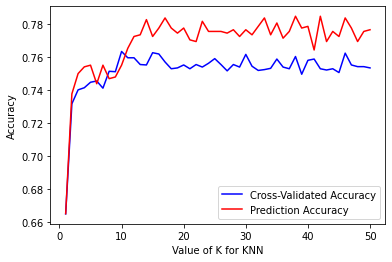

In [23]:
# plot the value of hiperparameter (x-axis) versus the accuracy (y-axis)
plt.plot(hiperparameter_range, train_scores, c='blue', label='Cross-Validated Accuracy')
plt.plot(hiperparameter_range, pred_scores, c='red', label='Prediction Accuracy')

plt.xlabel('Value of hiperparameter')
plt.ylabel('Accuracy')
plt.legend()



## Bibliografia e Aprofundamento
- [Bayesian x Random Search](https://miro.medium.com/max/1400/1*Xfnh-biDrMCECEO37qecKQ.png)
- [Outras otimizações: Evolutionary Search e Gradient Search](https://www.youtube.com/watch?v=TP9W7hmb0Bs)
- [XGBoost Hyperparameter Tuning - A Visual Guide](https://kevinvecmanis.io/machine%20learning/hyperparameter%20tuning/dataviz/python/2019/05/11/XGBoost-Tuning-Visual-Guide.html)
- [Como o tunning afeta o overfiting - bem legal!](https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Complexity_Learning_curves/Complexity_Learning_Analysis_Lending_Data.ipynb)
- [Plot de hiperparâmetros](https://www.ritchieng.com/machine-learning-efficiently-search-tuning-param/)